### Load data, see DatasetLoader.ipynb

In [1]:
import os

TRAIN_PATH = "../../Dataset/MHA/Training"
TEST_PATH = "../../Dataset/MHA/Test"

if not os.path.exists(TRAIN_PATH):
    print("Please update your data path to an existing folder.")
elif not '.mha' in os.listdir(TRAIN_PATH)[0]:
    print("The folder exists there are no MHA files found.")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.



 ../../Dataset/MHA/Training/TRV1P3 ,  28,  32,  34,  35,  37,  38
 ../../Dataset/MHA/Training/TRV1P4 ,  33,  34,  50
 ../../Dataset/MHA/Training/TRV1P5 ,  22,  24,  25,  26,  34,  35
 ../../Dataset/MHA/Training/TRV1P6 ,  42,  43
 ../../Dataset/MHA/Training/TRV1P7 ,  37,  38,  39,  40,  41,  42,  43,  45,  46,  47
 ../../Dataset/MHA/Training/TRV1P8 ,  11,  12,  13,  14,  21,  24,  25,  26,  28,  29,  30,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42
 ../../Dataset/MHA/Training/TRV2P2 ,  15,  36
 ../../Dataset/MHA/Training/TRV2P3 ,  11,  18,  26,  27,  28,  29,  30,  31,  32
 ../../Dataset/MHA/Training/TRV2P4 ,  11,  12,  20,  21,  22,  23,  25,  27,  28,  29,  33,  34
 ../../Dataset/MHA/Training/TRV2P6 ,  35,  36
 ../../Dataset/MHA/Training/TRV2P7 ,  12,  13,  14,  20,  23,  25,  26,  29,  30,  31,  32,  36,  37
 ../../Dataset/MHA/Training/TRV2P8 ,  30,  32,  33,  34,  35,  37,  38,  39,  40
 ../../Dataset/MHA/Training/TRV3P2 ,  32,  33
 ../../Dataset/MHA/Training/TRV3P3 ,  6,  7,  

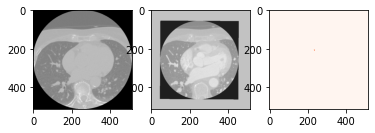

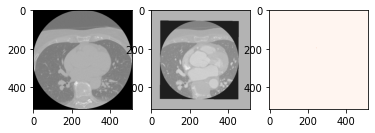

The distrubution of annotations in the trainset
Ratio with GT: 100.0 %
Area of GT in total: 0.021601782904730905 %


In [2]:
# from torch.utils.data import Dataset
from monai.data import Dataset
import monai
import torchsummary
import torch
import itk
from matplotlib import pyplot as plt
# import time
import numpy as np
# import shutil
from scipy.ndimage.filters import gaussian_filter

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, regImg_ext, transforms=None):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.images = self.load_mha_images(imagePaths,['CTI',regImg_ext,'R'])
		self.loadedImages = self.images['CTI']
		self.loadedMask = self.images['R']
		self.transforms = transforms

	def load_mha_images(self, paths, ext):
		img = dict()
		counter_reference = 0
		for i in paths:
			if len(ext)>1:
				seen = False
				R_image = np.clip(itk.GetArrayFromImage(itk.imread(i+""+ext[2]+".mha")),0,1)
				CTI_image = itk.GetArrayFromImage(itk.imread(i+""+ext[0]+".mha"))
				CTAI_image = itk.GetArrayFromImage(itk.imread(i+""+ext[1]+".mha"))
				if not (len(CTI_image) == len(CTAI_image) == len(R_image)):
					raise ValueError("Lengths (slices) of "+i+" are not the same!")
				for j in range(len(CTI_image)):
					if 1 in R_image[j]:
						if not seen:
							seen = True
							print('\n',i,end=" ")
						print(', ',j,end="")
						if ext[0] in img:
							img[ext[0]].append(torch.stack((torch.FloatTensor(CTI_image[j]),torch.FloatTensor(CTAI_image[j]))))
							img[ext[2]].append(torch.FloatTensor(R_image[j]))
						else:
							img[ext[0]] = [torch.stack((torch.FloatTensor(CTI_image[j]),torch.FloatTensor(CTAI_image[j])))]
							img[ext[2]] = [torch.FloatTensor(R_image[j])]
		return img

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.images['CTI'])

	def __getitem__(self, idx):
		# grab the image path from the current index
		image = self.loadedImages[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		mask = self.loadedMask[idx]
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

train_image_CTI_paths = list(filter(lambda x: 'CTI' in x,os.listdir(TRAIN_PATH)))
train_image_paths = []
for i in train_image_CTI_paths:
    train_image_paths.append(TRAIN_PATH+"/"+i[:6])


train_dataset = SegmentationDataset(train_image_paths,'CTAI_0')
print(len(train_dataset))

for i in range(2):
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(train_dataset[i][0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
    axes[1].imshow(train_dataset[i][0][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
    axes[2].imshow(train_dataset[i][1].numpy(),cmap=plt.cm.Reds)	# [i][1] 	GT
    plt.show()

count = 0
sumation = 0
for i in train_dataset:
    if 1 in i[1].numpy():
        sumation += np.sum(i[1].numpy())
        count += 1

print("The distrubution of annotations in the trainset")
print("Ratio with GT:",count/len(train_dataset)*100,"%")
print("Area of GT in total:",sumation/(len(train_dataset)*512*512)*100,"%")

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1,
    channels = (8, 8, 16, 16, 32),
    strides=(1, 1, 2, 2),
    num_res_units=2,
    bias=False,
    kernel_size=5,
).to(DEVICE)

torchsummary.summary(model,(2,512,512))

loss_function =  monai.losses.GeneralizedDiceLoss(sigmoid=True, batch=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              16
            Conv2d-2          [-1, 8, 512, 512]             400
    InstanceNorm2d-3          [-1, 8, 512, 512]               0
           Dropout-4          [-1, 8, 512, 512]               0
             PReLU-5          [-1, 8, 512, 512]               1
            Conv2d-6          [-1, 8, 512, 512]           1,600
    InstanceNorm2d-7          [-1, 8, 512, 512]               0
           Dropout-8          [-1, 8, 512, 512]               0
             PReLU-9          [-1, 8, 512, 512]               1
     ResidualUnit-10          [-1, 8, 512, 512]               0
         Identity-11          [-1, 8, 512, 512]               0
           Conv2d-12          [-1, 8, 512, 512]           1,600
   InstanceNorm2d-13          [-1, 8, 512, 512]               0
          Dropout-14          [-1, 8, 5

180


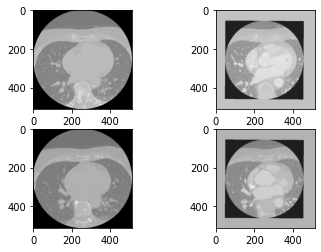

torch.Size([180, 2, 512, 512])
tensor([[[[-0.3564, -0.2426, -0.2357,  ..., -0.1381,  0.2451, -0.2970],
          [ 0.8174,  1.1679,  1.2457,  ...,  1.4459,  1.6992,  0.2176],
          [ 0.9663,  1.4652,  1.7073,  ...,  1.9770,  2.2120,  0.5443],
          ...,
          [ 1.3673,  1.8649,  2.0941,  ...,  2.3100,  2.4364,  0.5733],
          [ 1.4054,  2.0483,  2.2695,  ...,  2.5513,  2.4341,  0.6058],
          [ 1.2139,  1.9921,  2.3267,  ...,  2.4221,  2.1072,  0.5630]]],


        [[[-0.3625, -0.2545, -0.2510,  ..., -0.1530,  0.2348, -0.3046],
          [ 0.8093,  1.1650,  1.2387,  ...,  1.4372,  1.6924,  0.1975],
          [ 0.9531,  1.4580,  1.6965,  ...,  1.9687,  2.2062,  0.5243],
          ...,
          [ 1.3554,  1.8620,  2.0852,  ...,  2.3050,  2.4293,  0.5524],
          [ 1.3952,  2.0459,  2.2638,  ...,  2.5457,  2.4254,  0.5869],
          [ 1.1976,  1.9816,  2.3135,  ...,  2.4098,  2.0949,  0.5528]]]],
       grad_fn=<AddBackward0>)


In [20]:
# traindataset:[INDEX][ SCAN:[CT,CTA]] , GT ]
# print(model)
print(len(train_dataset))
x = torch.stack(train_dataset[:][0])

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(x[0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
axes[0][1].imshow(x[0][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
axes[1][0].imshow(x[1][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
axes[1][1].imshow(x[1][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
# axes[2].imshow(train_dataset[i][1].numpy(),cmap=plt.cm.Reds)	# [i][1] 	GT
plt.show()

print(x.size())
print(model(x[:2]))

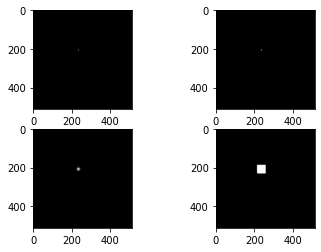

In [13]:
# TESTING GAUSSIAN FILTER
inputs, labels = train_dataset[0]
x = []
x.append(labels.numpy())
x.append(gaussian_filter(labels.numpy(),sigma=1))
x.append(gaussian_filter(labels.numpy(),sigma=5))
x.append(gaussian_filter(labels.numpy(),sigma=5))

x[3][np.where(x[3]>0)]=1

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(x[0],cmap=plt.cm.gray) # [i][0][0] CT
axes[0][1].imshow(x[1],cmap=plt.cm.gray) # [i][0][1] CTA
axes[1][0].imshow(x[2],cmap=plt.cm.gray) # [i][0][0] CT
axes[1][1].imshow(x[3],cmap=plt.cm.gray) # [i][0][1] CTA

In [21]:
def train_model(model,train_ds,epochs):
    # start a typical PyTorch training
    epoch_loss_values = list()
    metric_values = list()
    for epoch in range(epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_ds:
            step += 1
            inputs, labels = batch_data[0].to(DEVICE), batch_data[1].to(DEVICE)
            optimizer.zero_grad()

            #Labels smoothing
            labels = gaussian_filter(labels.numpy(), sigma=5)
            labels[np.where(labels>0)]=1

            inputs = inputs.unsqueeze(1).permute(1,0,2,3)
            labels = labels.unsqueeze(0).unsqueeze(0)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds)
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}\r")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

train_model(model,train_dataset,30)

----------
epoch 1/10
50/180, train_loss: 0.9995
100/180, train_loss: 0.9991
150/180, train_loss: 0.9988
epoch 1 average loss: 0.9991
----------
epoch 2/10
50/180, train_loss: 0.9995
100/180, train_loss: 0.9991
150/180, train_loss: 0.9987


KeyboardInterrupt: 